# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2)


This notebook provides a base clustering for ordinary and scripted trips together without feature engineering and K-Means with k=3. k=3 follows the naive assumption that the cluster structure is only influenced by the labels. 

We found that there are the following problems with this base line approach:
- Mode "METRO" and "TRAM" are not clustered distinctly
- Mode "WALK" has too many clusters
- We have to cut more than 30 seconds from the scripted trips during preprocessing

## TO-DO

- Find better features
- Visualise existing features

In [71]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
#file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)
xyz_euclidean_distances = pd.read_csv(os.path.join(data_dir,"preprocessed","preprocessed_data_individual_euclidean_xyz.csv"), sep=";")
xyz_euclidean_distances = xyz_euclidean_distances[xyz_euclidean_distances["scripted"] == 1]

In [73]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]
scripted_trips_only = trips_cut_per_30_sec[trips_cut_per_30_sec["scripted"] == 1]
scripted_trips_only = scripted_trips_only.reset_index(drop=True)



#euclidean_distances = xyz_euclidean_distances.reset_index(drop=True)

euclidean_distances = Preprocessor.calculate_distance_for_n2(scripted_trips_only, metric="euclidean")
#correlation_distances = Preprocessor.calculate_distance_for_n2(scripted_trips_only, metric="correlation")
#file_path = os.path.join(data_dir, "preprocessed","449_train_loss_0.0771002_encodings.csv")
#encoded_distances = pd.read_csv(file_path, sep=";", index_col=False).drop(["Unnamed: 0"],axis=1)

## Calculate Maximum Break Length == Find longest decreasing pattern

In [74]:
longest_decreasing_patterns = list()

scripted_trips_copy = scripted_trips_only.drop(categorical_columns,axis=1)
for index in range(scripted_trips_copy.shape[0]):
    trip_i = np.array(scripted_trips_copy.iloc[index],dtype=np.float32)
    smallest_list = []
    smaller_value = trip_i[0]
    smallest_value_list = []
    found_larger_value = 0
    threshold = 20
    for value_i in trip_i:
        if value_i <= smaller_value:
            smaller_value = value_i
            smallest_list.append(smaller_value)
        else:
            found_larger_value += 1
            smallest_value_list.append(len(smallest_list))
        if found_larger_value > threshold:
            found_larger_value = 0
            smaller_value = 0.0
            smallest_list=list()
        
    
    if not smallest_value_list:
        longest_decreasing_patterns.append(0)
    else:
        longest_decreasing_patterns.append(np.max(smallest_value_list))
    #print(max(smallest_value_list))       

len(longest_decreasing_patterns)
        

911

## Calculate Maximum Acceleration Length == Find longest increasing pattern

In [75]:
longest_increasing_patterns = list()

scripted_trips_copy = scripted_trips_only.drop(categorical_columns,axis=1)
for index in range(scripted_trips_copy.shape[0]):
    trip_i = np.array(scripted_trips_copy.iloc[index],dtype=np.float32)
    smallest_list = []
    larger_value = 0.0
    smallest_value_list = []
    found_smaller_value = 0
    threshold = 20
    for value_i in trip_i:
        if larger_value <= value_i:
            larger_value = value_i
            smallest_list.append(larger_value)
        else:
            found_smaller_value += 1
            smallest_value_list.append(len(smallest_list))
        if found_larger_value > threshold:
            larger_value = 0.0
            found_smaller_value = 0
            smallest_list=list()
    
    if not smallest_value_list:
        longest_increasing_patterns.append(0)
    else:
        longest_increasing_patterns.append(np.max(smallest_value_list))
    #print(max(smallest_value_list))       

len(longest_increasing_patterns)

911

## Visualisation of Engineered Features

In [76]:
features = euclidean_distances.loc[:,["mode", "notes","scripted", "token", "trip_id"]]
features["longest_break_period"] = np.array(longest_decreasing_patterns, dtype=np.float16) * 1/20.0
features["longest_acceleration_period"] = np.array(longest_increasing_patterns, dtype=np.float16) * 1/20.0

helper = ([isinstance(val,str) for val in features["longest_break_period"]])
for i in helper:
    if i:
        print("shit")
print(len((features["longest_break_period"] == 0)))

911


In [77]:
features.drop("token",axis=1).groupby(["mode"]).describe()

longest_acceleration_period                                          \
                            count      mean       std       min       25%   
mode                                                                        
METRO                       301.0  0.859863  0.857910  0.000000  0.399902   
TRAM                        328.0  0.961914  1.228516  0.049988  0.350098   
WALK                        282.0  0.594727  0.507324  0.099976  0.300049   

                                     longest_break_period                      \
            50%       75%        max                count      mean       std   
mode                                                                            
METRO  0.600098  1.099609   8.648438                301.0  0.295654  0.283203   
TRAM   0.649902  1.150391  13.250000                328.0  0.459717  1.235352   
WALK   0.399902  0.649902   2.800781                282.0  0.307129  0.268311   

                                                          
            min       25%       50%       75%        max  
mode                                                      
METRO  0.049988  0.150024  0.199951  0.350098   1.599609  
TRAM   0.000000  0.099976  0.250000  0.549805  17.750000  
WALK   0.049988  0.150024  0.199951  0.350098   1.599609

## Summary Statistics of euclidean distances:

In [10]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_only = euclidean_distances.drop(categorical_columns,axis=1)
#print(trips_only.shape)
#trips_only.head(5)

In [66]:
percentiles=[0.1*(i+1) for i in range(10)]
summaries_euclidean = trips_only.transpose().describe(percentiles=percentiles).T
summaries_euclidean = summaries_euclidean.drop(["count","min","max","mean"],axis=1)
summaries_euclidean.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%
0,45.061287,3.610770,6.760964,10.500196,12.577645,15.733230,17.148232,54.150599,102.440698,112.152077,161.944225
1,44.920779,5.801042,7.136099,9.403037,11.671881,14.076364,15.372234,54.156080,101.997231,111.678237,160.342251
2,45.221465,4.131189,5.964888,9.451812,11.626179,14.426404,15.761094,53.832504,101.804602,111.827993,161.368728
3,45.265942,5.089719,6.662610,7.803089,9.774377,12.297512,13.692647,53.121159,101.129707,111.193785,159.448943
4,44.961413,6.208727,7.607290,8.426689,10.078955,12.347625,13.698369,53.492378,101.022031,111.266889,160.030718


In [69]:
summaries_euclidean["longest_break_period"] = np.array(longest_decreasing_patterns,dtype=np.float32)
summaries_euclidean["longest_acceleration_period"] = np.array(longest_increasing_patterns,dtype=np.float32)
for colname in categorical_columns:
    summaries_euclidean[colname] = euclidean_distances[colname]


In [78]:
max_values = summaries_euclidean.groupby("mode").max()[["longest_break_period","longest_acceleration_period"]]
print("Maximum:")
display(max_values)
print("Minimum:")
min_values = summaries_euclidean.groupby("mode").min()[["longest_break_period","longest_acceleration_period"]]
display(min_values)

Maximum:


,longest_break_period,longest_acceleration_period
mode,,
METRO,23.0,171.0
TRAM,354.0,257.0
WALK,28.0,54.0


Minimum:


,longest_break_period,longest_acceleration_period
mode,,
METRO,1.0,0.0
TRAM,0.0,1.0
WALK,1.0,5.0


## Apply PCA to euclidean distances and to summaries

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
trips_reduced = pd.DataFrame(pca.fit_transform(trips_only))

pca_2 = PCA(n_components=5)
summaries_euclidean = pd.DataFrame(scale(summaries_euclidean),columns=summaries_euclidean.columns)

summaries_reduced = pd.DataFrame(pca_2.fit_transform(summaries_euclidean))


features_used = summaries_reduced
#trips_reduced.head()

In [ ]:
summaries_euclidean

In [50]:
features_used.head()

,0,1,2,3,4
0,-13.237988,-2.081324,-2.141590,0.323981,0.023251
1,-13.068901,-0.088094,-2.187595,0.228364,-0.007582
2,-12.156519,-1.168627,-2.186795,0.301628,0.015585
3,-13.235299,-2.080133,-2.319639,0.200658,-0.017756
4,-9.082433,-0.424392,-2.199868,0.211234,0.008920


### Plot first two principle components

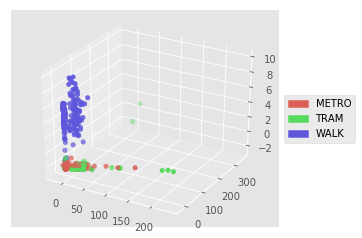

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors, color_patches = get_color_encoding(euclidean_distances["mode"])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          handles=color_patches)
ax.scatter(features_used[0],features_used[1],features_used[2],c=colors)
plt.show();

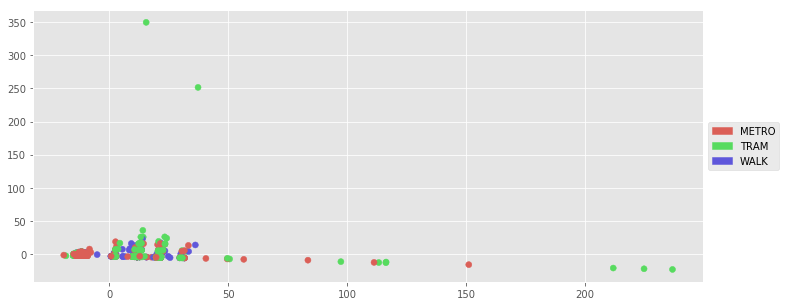

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
colors, color_patches = get_color_encoding(euclidean_distances["mode"])


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          handles=color_patches)
ax.scatter(features_used[0],features_used[1],color=colors);

------
## Create Base Model with Euclidean Distance and KMeans Clustering

Use summaries of each distance

In [19]:
#from sklearn.cluster import DBSCAN
#random_state = 0
#features_used = encoded_distances.drop(categorical_columns,axis=1)
#db = DBSCAN(eps=0.7, min_samples=5).fit(features_used)

#cluster_labels = db.labels_
#print("unique cluster labels: ", set(cluster_labels))
#euclidean_distances["cluster_labels"]=cluster_labels


In [51]:
from sklearn.cluster import KMeans
random_state = 0

#Naive asumption of 3 clusters due to 3 labels Walk, Metro and Tram 
kmeans = KMeans(n_clusters=3, random_state=random_state).fit(features_used)
cluster_labels = kmeans.labels_
euclidean_distances["cluster_labels"]=cluster_labels

### Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [53]:
# how well does it capture the label information
get_clustering_performance(features_used, cluster_labels,
                           true_labels=euclidean_distances["mode"])

['Estimated number of clusters: 3',
 'True number of clusters: 3',
 'Homogeneity: 0.093',
 'Completeness: 0.006',
 'V-measure: 0.012',
 'Adjusted MI: 0.004',
 'Silhouette Coefficient: 0.872']

In [54]:
# Uncomment if you want to explore full dataframe
#with pd.option_context('display.max_rows', None):
#    display(scripted_trips[scripted_trips["scripted"]==0])

## Visualise clustering result for one specific trip

Select one trip:

In [55]:
selected_trip = 5
small_df_trip = euclidean_distances[euclidean_distances.trip_id == selected_trip]
small_df_trip.head()

,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,distance_9,...,distance_907,distance_908,distance_909,distance_910,mode,notes,scripted,token,trip_id,cluster_labels
79,113.959151,113.237760,113.624017,113.060284,112.991381,113.035429,112.229122,112.546169,112.552454,112.443241,...,114.868633,114.704943,114.597875,114.543098,WALK,scripted,1,355007075245007,5,0
80,112.139829,111.420248,111.726362,110.937990,111.018318,111.061675,110.101846,110.496921,110.474658,109.939416,...,113.009115,112.854253,112.727050,112.617299,WALK,scripted,1,355007075245007,5,0
81,116.379215,115.827600,116.162356,115.459892,115.376596,115.494884,115.119478,114.939158,115.029341,114.394016,...,117.315493,117.161296,117.041563,116.985896,WALK,scripted,1,355007075245007,5,0
82,117.738323,117.222487,117.396623,116.639942,116.840193,116.833764,116.241916,116.182548,116.204136,115.995247,...,118.677202,118.544653,118.404310,118.335081,WALK,scripted,1,355007075245007,5,0
83,114.690394,114.293029,114.454485,113.610813,113.698914,113.729782,112.821173,113.074732,113.085860,112.732869,...,115.743812,115.593577,115.449474,115.388820,WALK,scripted,1,355007075245007,5,0


First, make sure that cut trips and original trips are the same by checking the first values in the total column

In [56]:
trips_cut_per_30_sec[trips_cut_per_30_sec.trip_id == selected_trip].head(1)

,snippet_0,snippet_1,snippet_2,snippet_3,snippet_4,snippet_5,snippet_6,snippet_7,snippet_8,snippet_9,...,snippet_595,snippet_596,snippet_597,snippet_598,snippet_599,mode,notes,scripted,token,trip_id
103,14.1751,14.4321,16.5716,12.784,8.81912,6.02161,4.1676,4.49849,9.06437,22.419,...,13.8621,11.4552,7.93498,7.35003,4.85618,WALK,scripted,1,355007075245007,5


In [57]:
trips_unpacked = Preprocessor.unpack_all_trips(dfs)
#trips_unpacked = [trip_i for trip_i in trips_unpacked if "scripted" in str(trip_i["annotation"]["notes"][0]).lower()]

acceleration_data_trip = trips_unpacked[selected_trip]["sensor"]
acceleration_data_trip = deepcopy(acceleration_data_trip[acceleration_data_trip.sensor == "acceleration"])
# Important, because indices are not unique
acceleration_data_trip = acceleration_data_trip.reset_index(drop=True)

acceleration_data_trip.head()

,time,total,x,y,z,sensor
0,2017-12-12 15:44:19.973,14.175124,-0.285985,13.933329,2.591274,acceleration
1,2017-12-12 15:44:20.018,14.432075,3.002282,13.870204,2.624601,acceleration
2,2017-12-12 15:44:20.068,16.571573,7.334171,14.842432,-0.727459,acceleration
3,2017-12-12 15:44:20.118,12.784040,3.683990,12.227089,-0.598481,acceleration
4,2017-12-12 15:44:20.168,8.819115,0.451098,7.922455,3.848117,acceleration


During the cutting process the last segments which are less than 30 seconds are dropped, thats why we have to drop them in the original dataframe as well:

In [58]:
labels = get_cluster_labels(small_df_trip["cluster_labels"])
diff = acceleration_data_trip.shape[0] - len(labels)
rows_to_be_dropped = acceleration_data_trip.tail(diff).index
acceleration_data_trip = acceleration_data_trip.drop(rows_to_be_dropped)
acceleration_data_trip["cluster_labels"]= labels
acceleration_data_trip.head()

,time,total,x,y,z,sensor,cluster_labels
0,2017-12-12 15:44:19.973,14.175124,-0.285985,13.933329,2.591274,acceleration,0
1,2017-12-12 15:44:20.018,14.432075,3.002282,13.870204,2.624601,acceleration,0
2,2017-12-12 15:44:20.068,16.571573,7.334171,14.842432,-0.727459,acceleration,0
3,2017-12-12 15:44:20.118,12.784040,3.683990,12.227089,-0.598481,acceleration,0
4,2017-12-12 15:44:20.168,8.819115,0.451098,7.922455,3.848117,acceleration,0


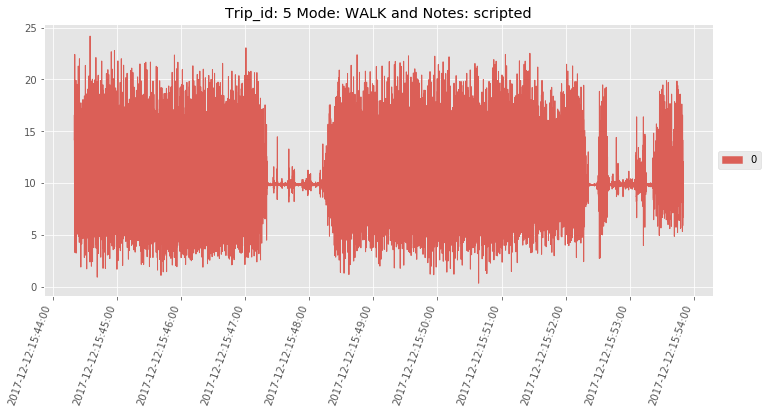

In [59]:
mode = trips_unpacked[selected_trip]["annotation"]["mode"][0]
notes = trips_unpacked[selected_trip]["annotation"]["notes"][0]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Trip_id: {} Mode: {} and Notes: {}".format(selected_trip, mode,notes))
plot_timeseries_clustering(acceleration_data_trip["time"],acceleration_data_trip["total"], acceleration_data_trip["cluster_labels"], ax=ax)

## Plot the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [60]:
def get_distribution_of_cluster_labels_for(target, distance_matrix):
    column_names = ["count_cluster_"+str(i) for i in np.sort(distance_matrix["cluster_labels"].unique())]
    column_names += [target]
    dist_df = pd.DataFrame(columns=column_names)
    # Collect cluster counts per mode
    for index, target_value in enumerate(distance_matrix[target].unique()):
        distance_per_target_value = distance_matrix[distance_matrix[target]==target_value]
        dist_df.loc[index,target]=target_value
        cluster_label_dist = distance_per_target_value.groupby("cluster_labels").count()[target]
        for cluster_id, label_count in cluster_label_dist.iteritems():
                dist_df.loc[index,"count_cluster_"+str(cluster_id)]=label_count

        dist_df.fillna(0,inplace=True)

    return dist_df

mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,mode
0,298.0,0.0,3.0,METRO
1,282.0,0.0,0.0,WALK
2,319.0,2.0,7.0,TRAM


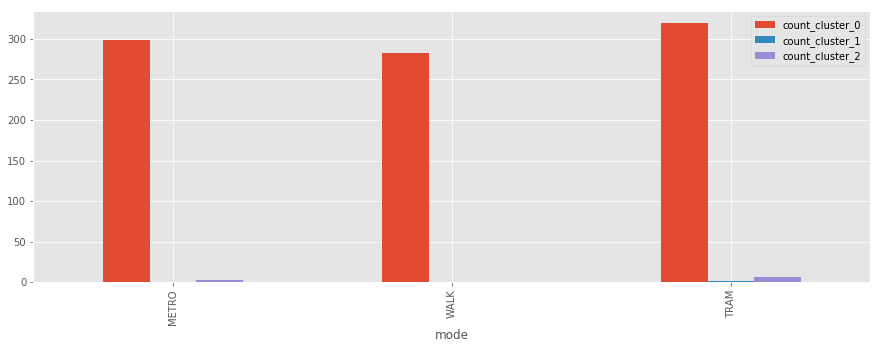

In [61]:
mode_dist_df.set_index("mode").plot(kind="bar",figsize=(15,5));

## Plot distribution of cluster labels for scripted and tokens

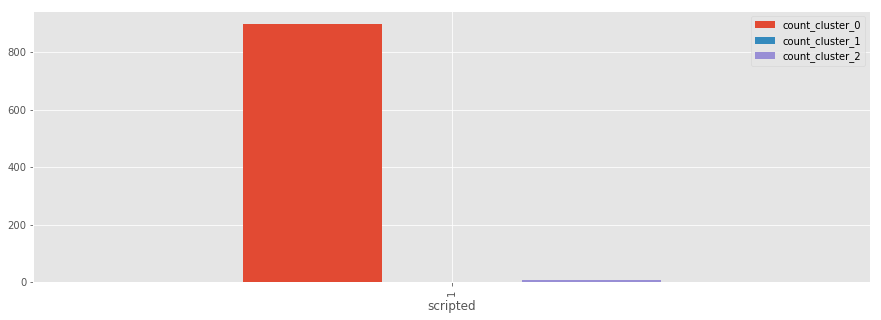

In [62]:
scripted_dist_df = get_distribution_of_cluster_labels_for("scripted", euclidean_distances)
scripted_dist_df.set_index("scripted").plot(kind="bar",figsize=(15,5));

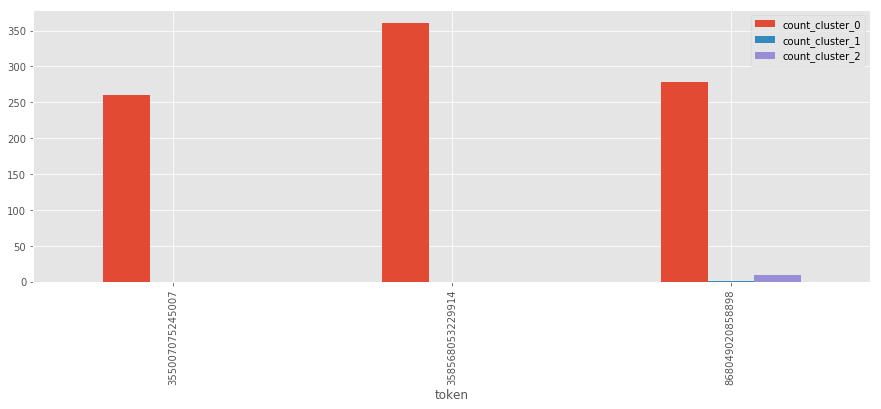

In [63]:
token_dist_df = get_distribution_of_cluster_labels_for("token", euclidean_distances)
token_dist_df.set_index("token").plot(kind="bar",figsize=(15,5));

## Plot all trips with their clustering labels

Produce this plot more conveniently by writing:

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



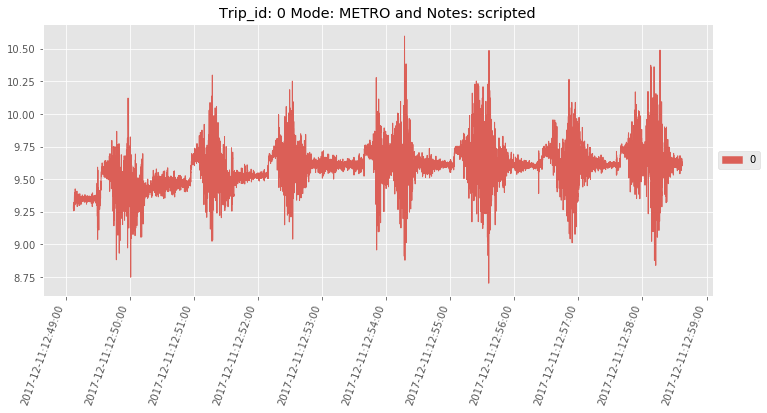

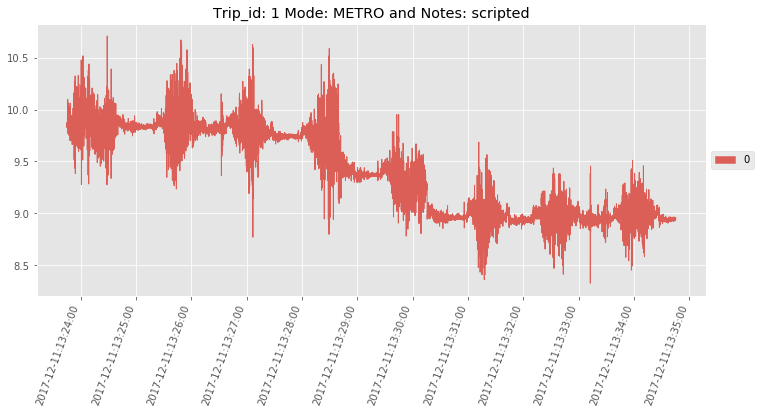

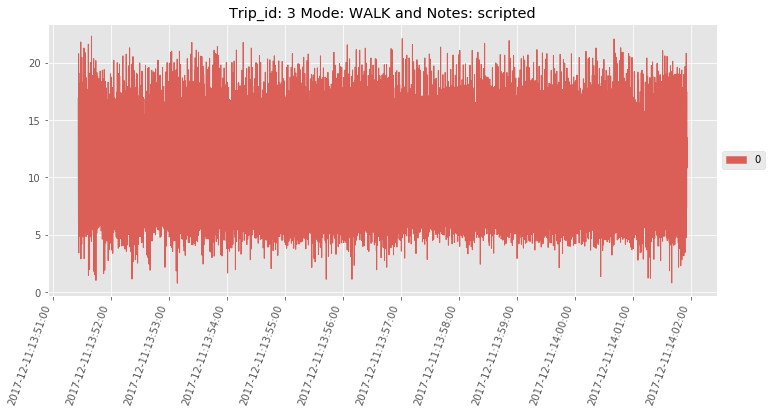

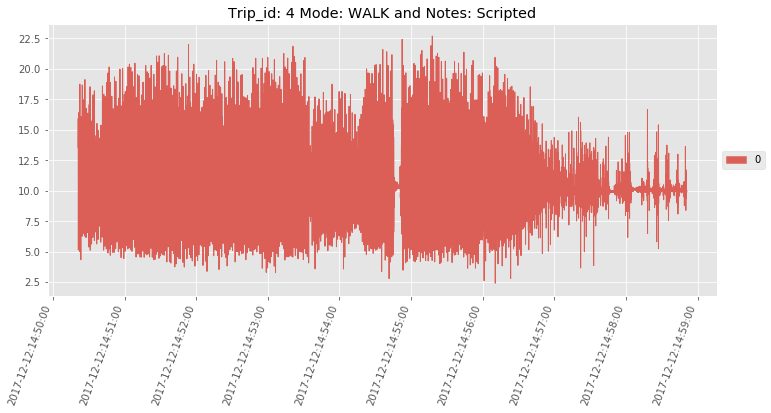

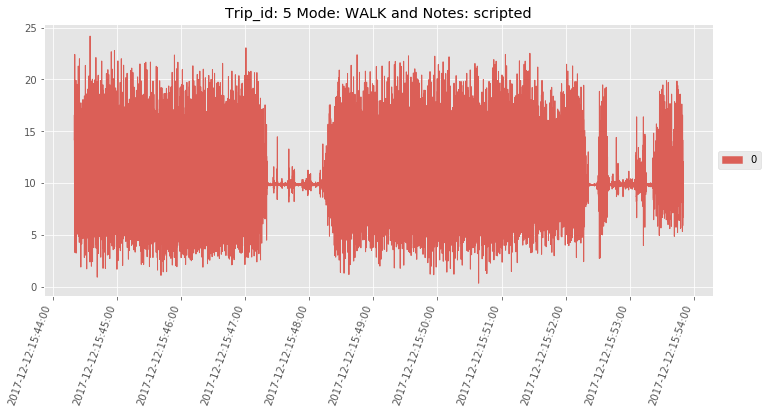

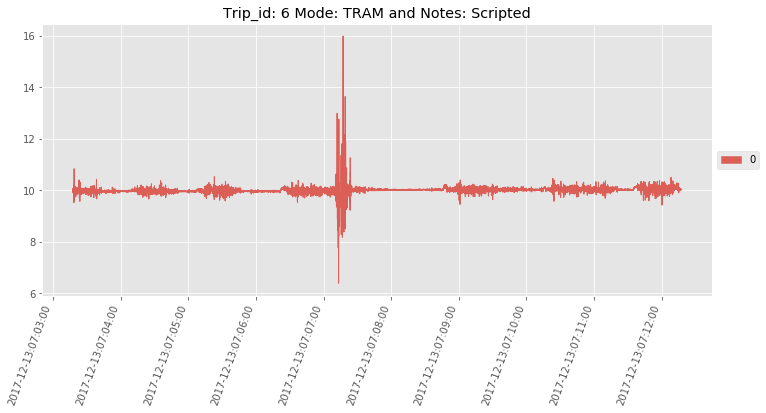

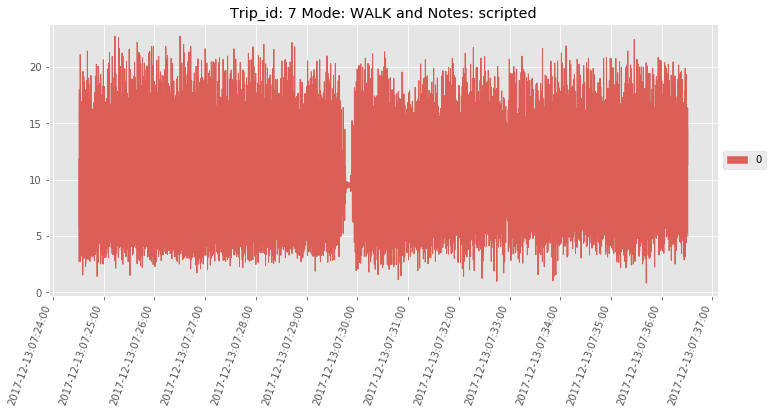

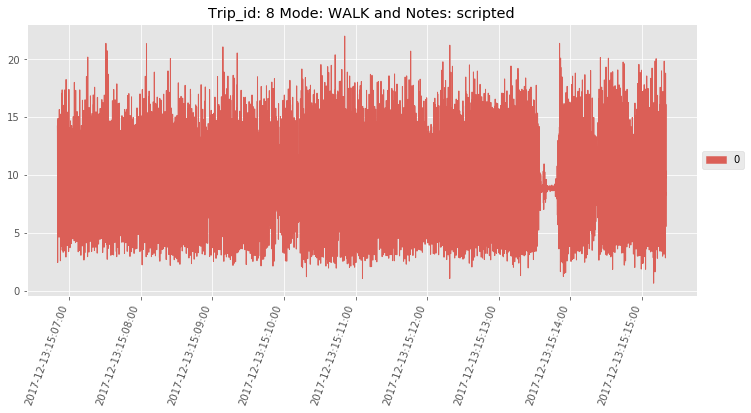

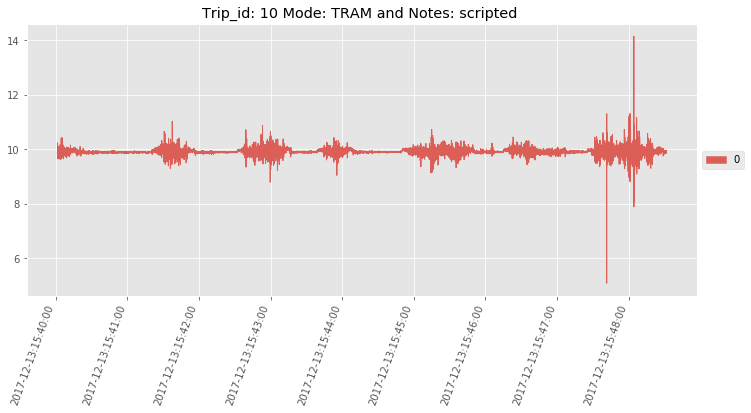

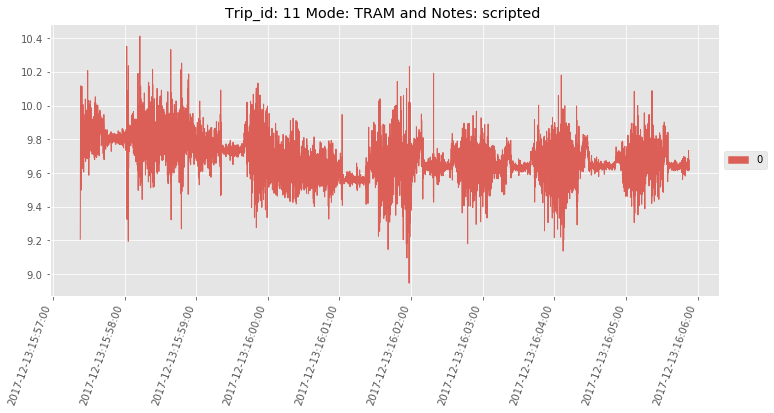

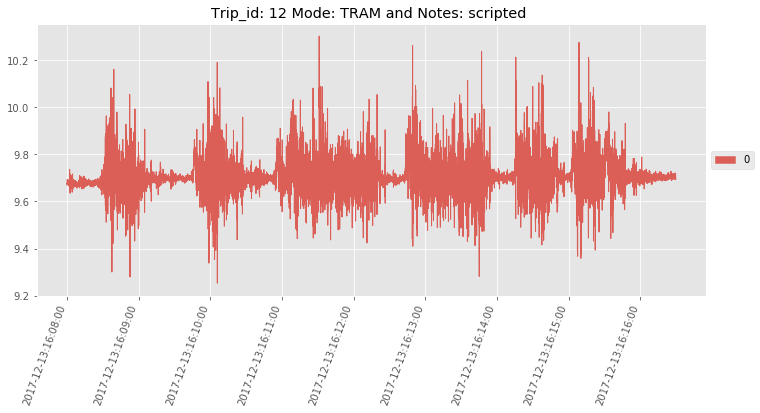

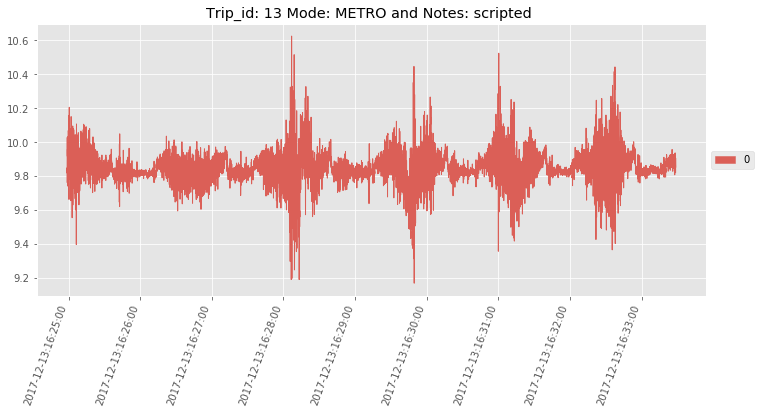

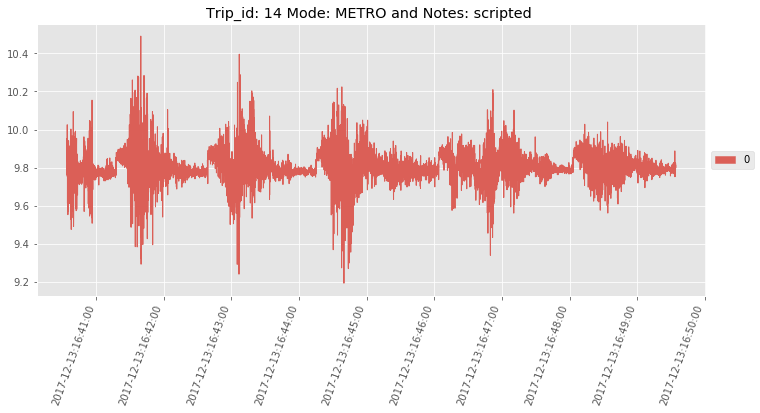

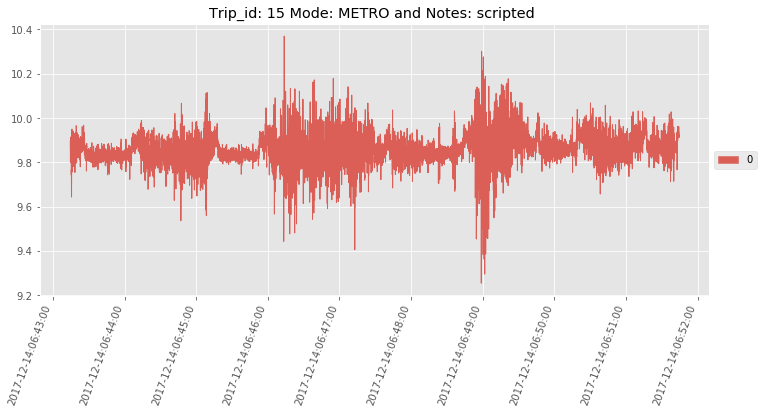

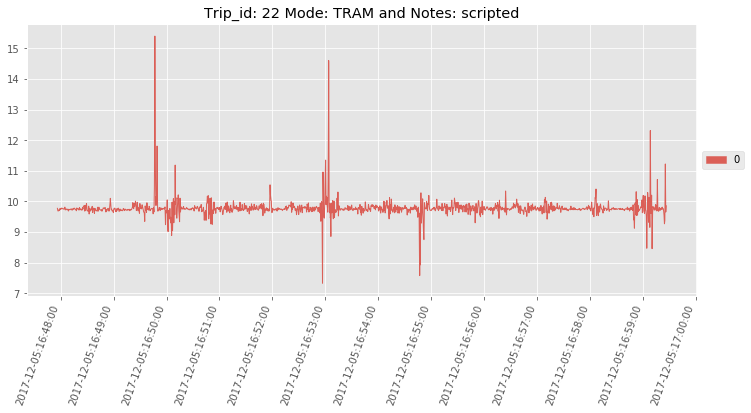

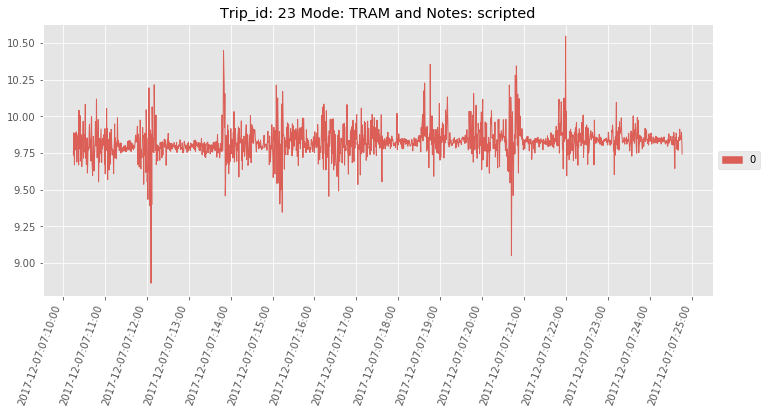

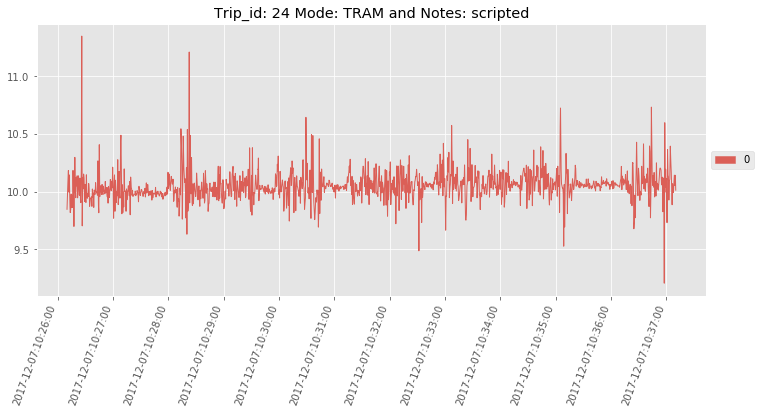

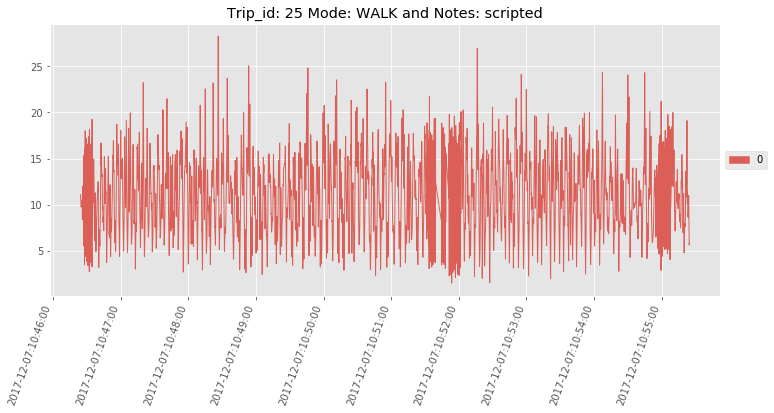

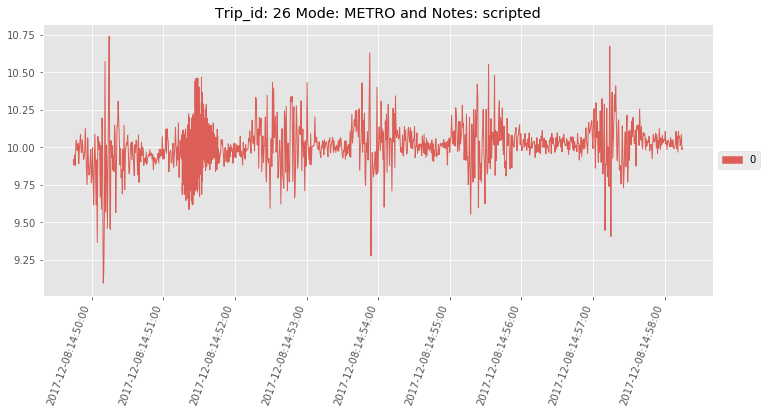

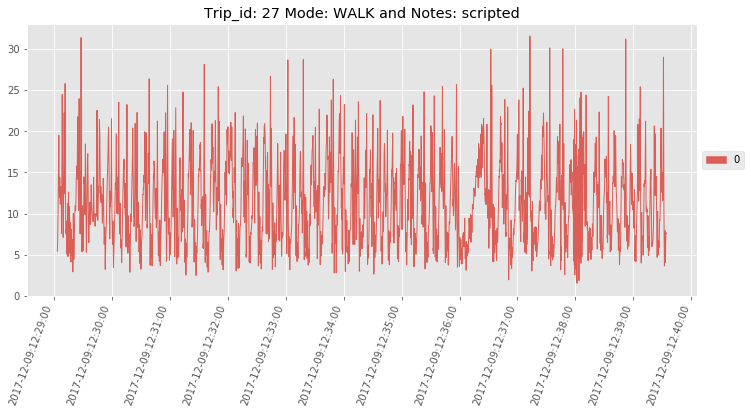

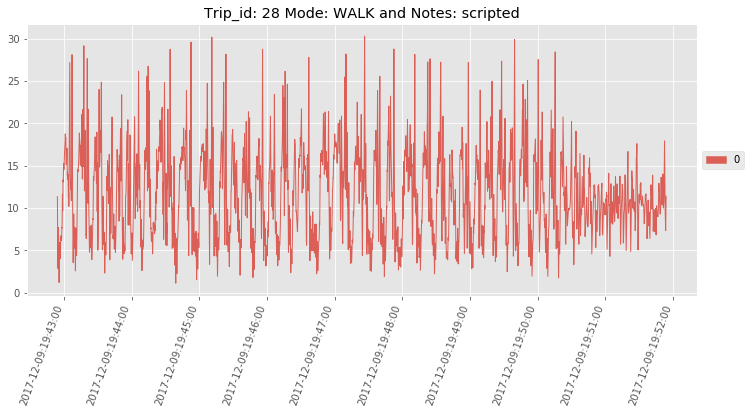

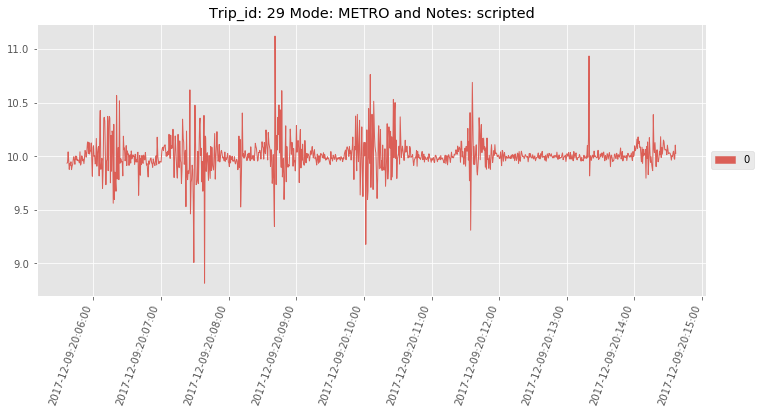

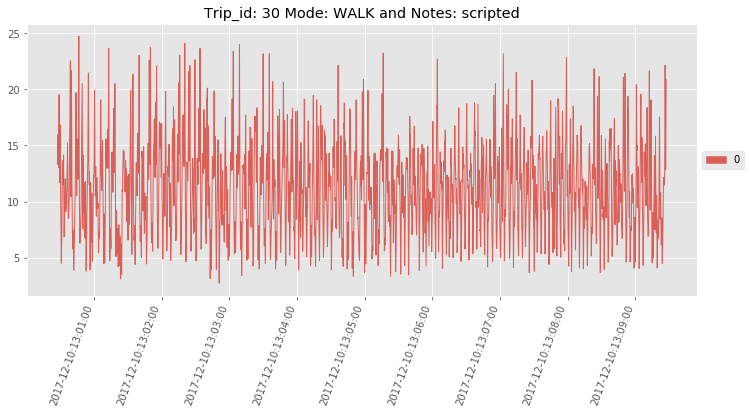

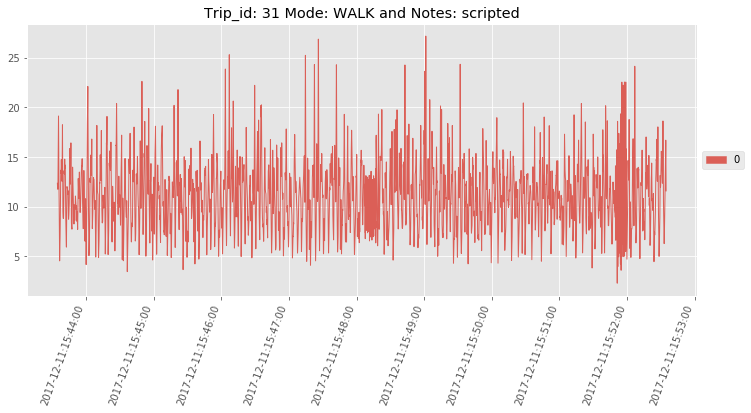

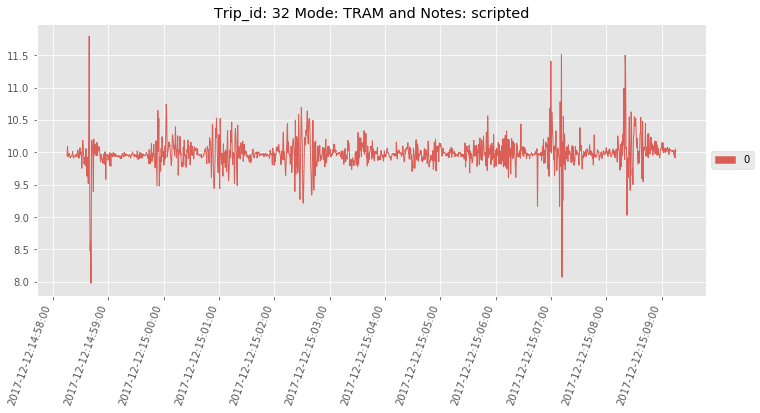

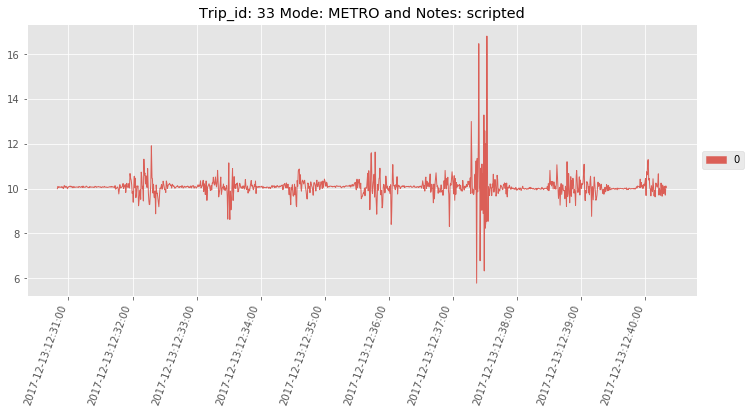

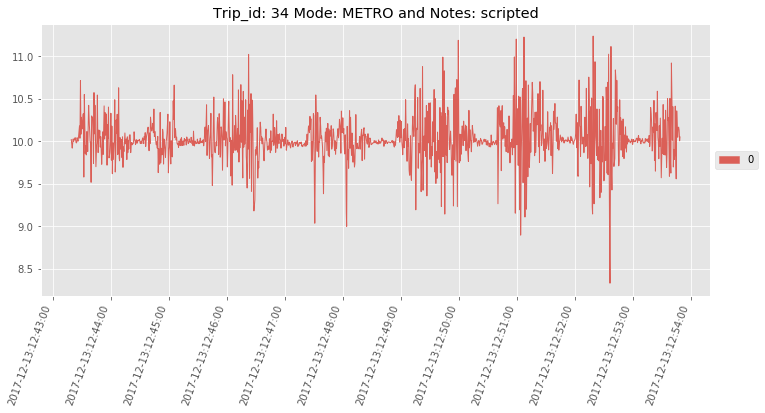

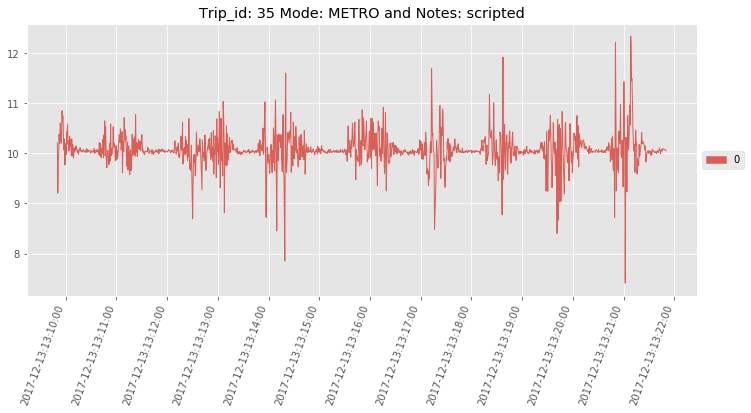

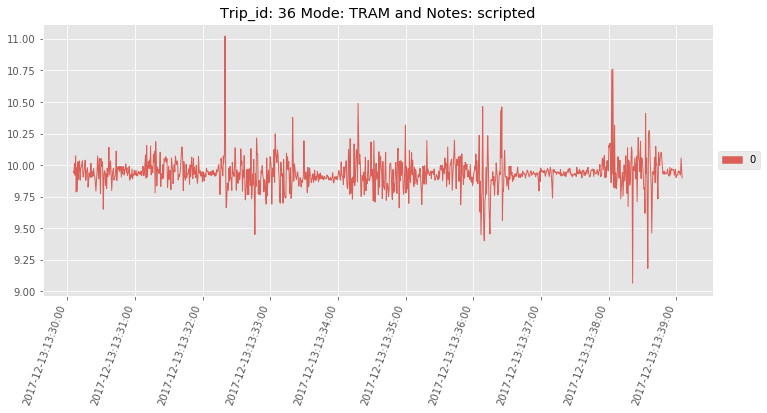

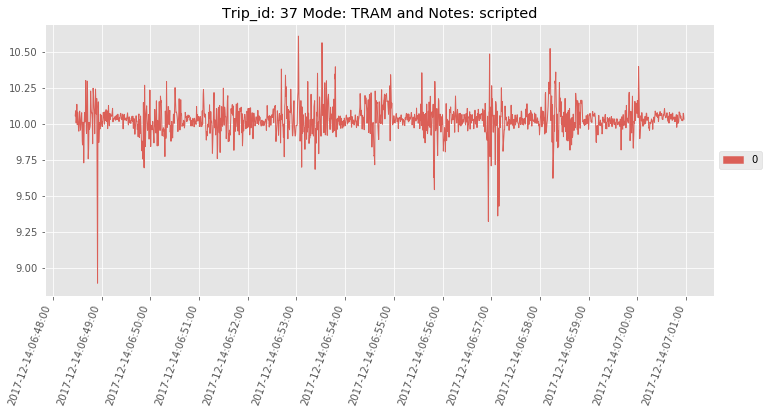

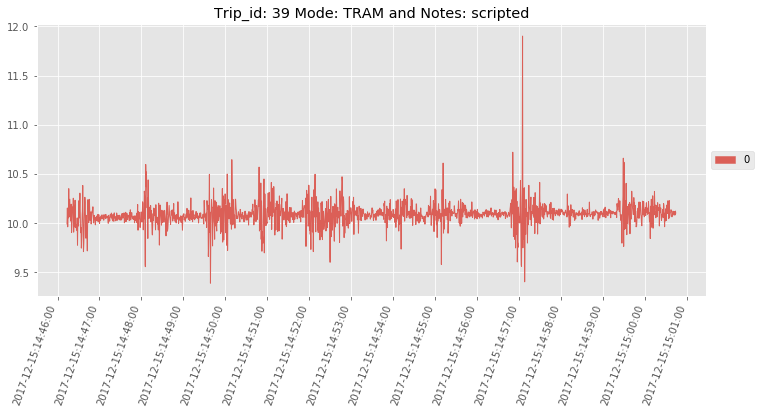

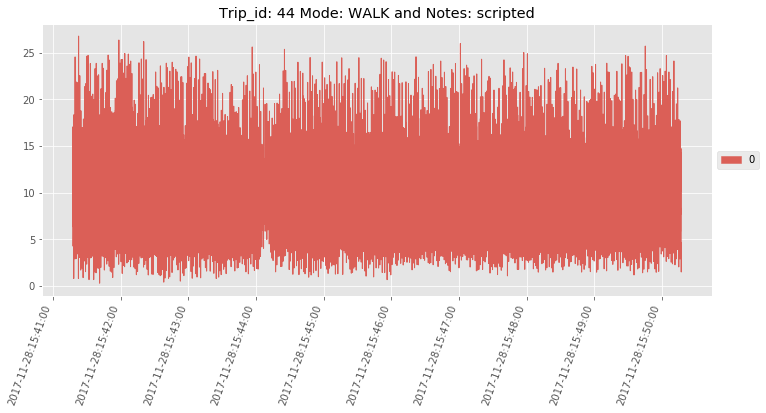

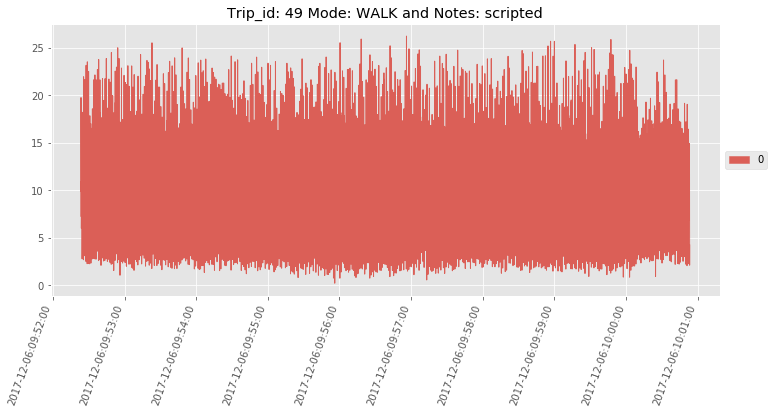

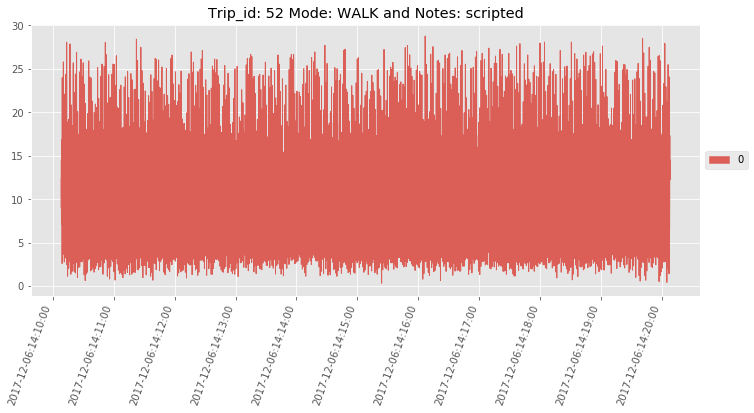

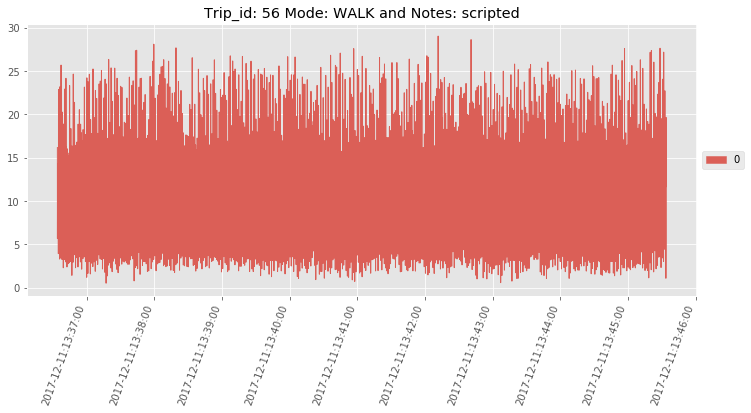

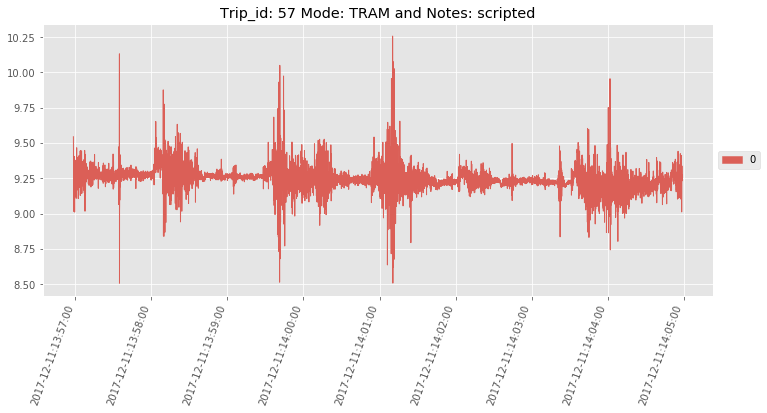

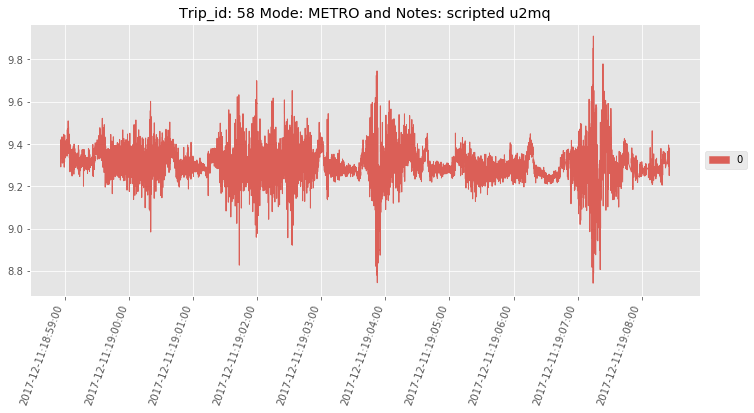

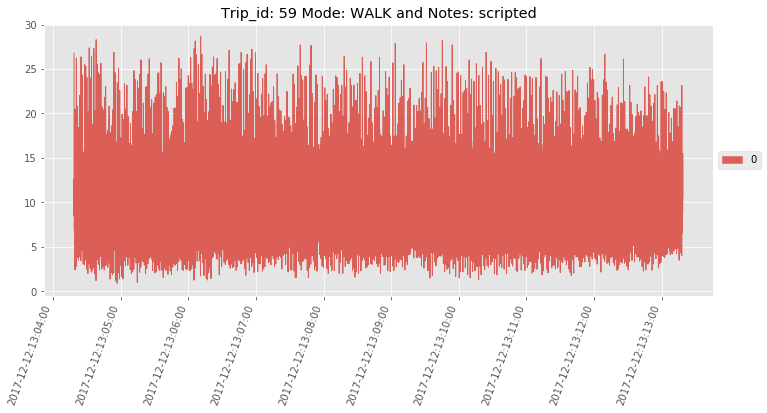

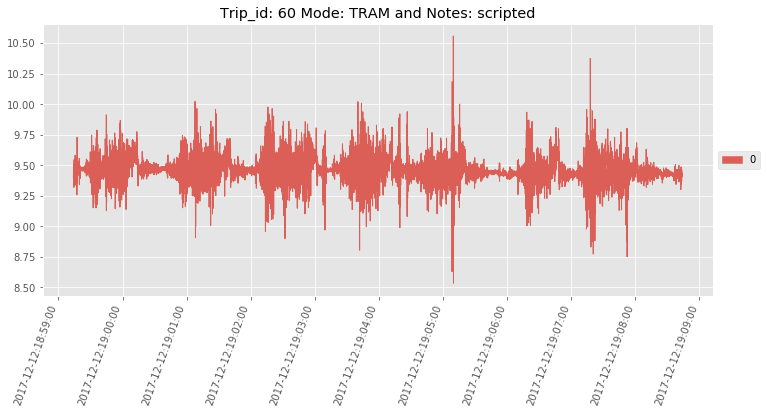

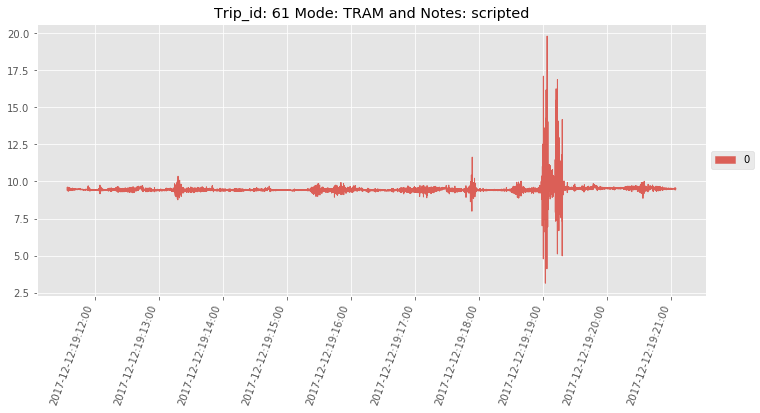

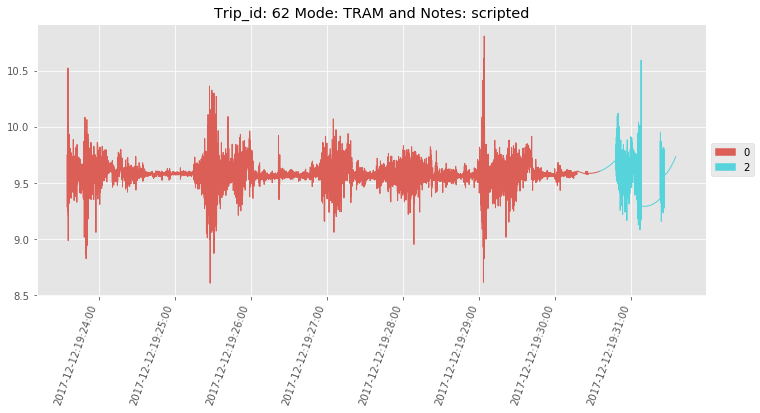

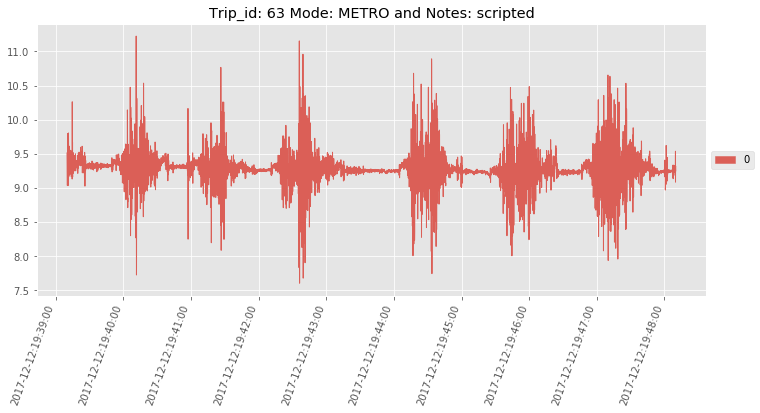

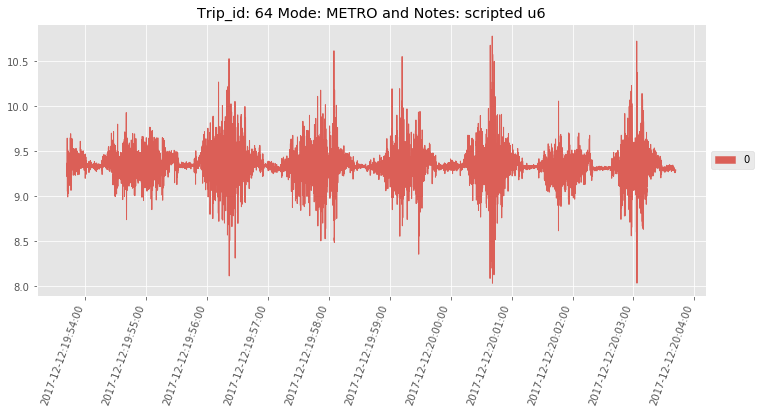

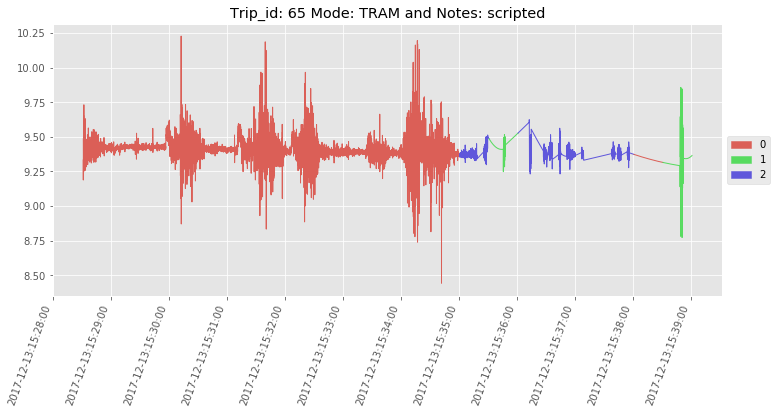

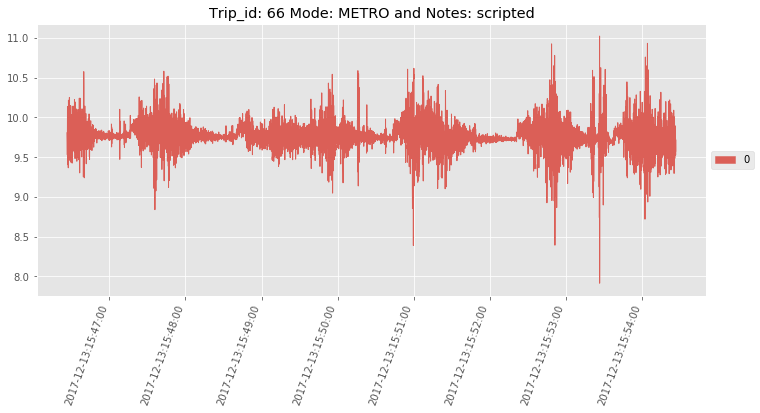

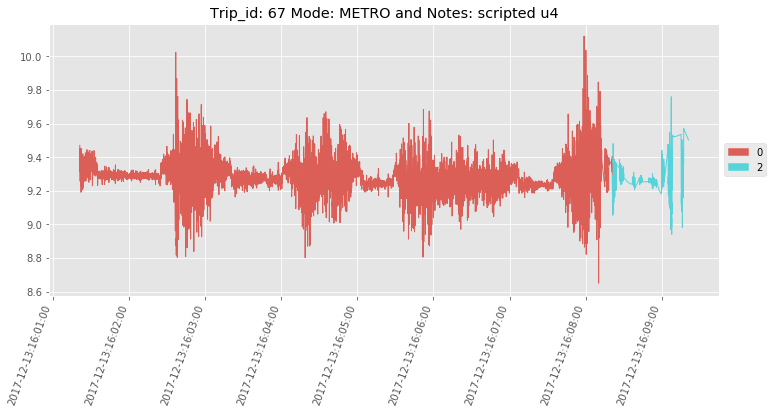

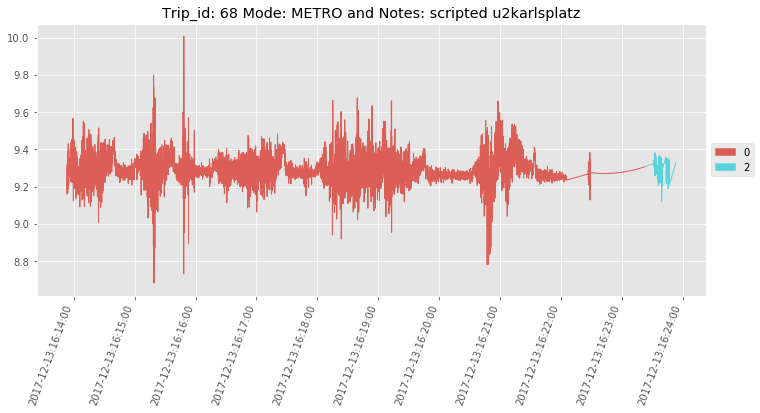

In [64]:

trip_ids = [i for i in euclidean_distances.trip_id.unique()]

for trip_id in trip_ids:
    time, total, labels = \
        get_plot_timeseries_clustering_variables(euclidean_distances,
                                                 trips_unpacked, 
                                                 trip_id, 
                                                 sensor_type="acceleration")


    mode = trips_unpacked[trip_id]["annotation"]["mode"][0]
    notes = trips_unpacked[trip_id]["annotation"]["notes"][0]

    title_format = "Trip_id: {} Mode: {} and Notes: {}"

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(title_format.format(trip_id,mode,notes))
    plot_timeseries_clustering(time,total, labels, ax=ax)